In [1]:
import numpy as np
import matplotlib.pyplot as plt
from decorator import append
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from BayesianLLNN import BaseNetwork
from BayesianLLNN import BayesianLastLayer,PredLastLayer,TrainLastLayer
from baseNN import GetNeuralNetwork, PredNormal, TrainNN
from sklearn.metrics import mean_squared_error

In [2]:
def sample_strict_ood(n, loc=-6, scale=1, min_val=-np.inf, max_val=-4):
    samples = []
    while len(samples) < n:
        s = np.random.normal(loc, scale, size=(n, 1))
        s = s[s < max_val]
        samples.extend(s.tolist())
    return np.array(samples[:n]).astype(np.float32).reshape(-1, 1)

In [3]:
np.random.seed(123)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
#simulate data ID bereich [-4,4]
X_train = np.random.uniform(-4,4,800).reshape(-1,1).astype(np.float32)
#by adding the gaussian noise we are introducing aleatoric uncertainty
y_train = (np.sin(X_train) +np.random.normal(scale=0.4,size=X_train.shape)).astype(np.float32)

# We sample from a normal gaussian for the OOD data.
#WE ARE introducing OOD TO TESTSET
X_id = np.random.uniform(-4, 4, size=(100, 1)).reshape(-1,1)   .astype(np.float32)      # ID
X_ood_left = sample_strict_ood(50)
X_ood_right = sample_strict_ood(50,6,1,min_val=4,max_val=np.inf)# right OOD
X_test = np.vstack([X_ood_left, X_id, X_ood_right])
#X_test = np.linspace(-8, 8, 200).reshape(-1, 1).astype(np.float32)

y_test = (np.sin(X_test) + np.random.normal(scale=0.4,size=X_test.shape)).astype(np.float32)

tenX = torch.from_numpy(X_train).to(device)
tenY = torch.from_numpy(y_train).to(device)
tenXTest = torch.from_numpy(X_test).to(device)
tenYTest = torch.from_numpy(y_test).to(device)
tenDF = TensorDataset(tenX,tenY)
trainLoader = DataLoader(tenDF,batch_size=32,shuffle=True)
InDist = [False]*50
InDist.extend([True]*100)
InDist.extend([False]*50)

In [4]:
mapNN = GetNeuralNetwork()
TrainNN(mapNN, trainLoader, epochs=100)
mean_map, std_map = PredNormal(mapNN, tenXTest)

Epoch: 0 | Loss: 0.34958
Epoch: 20 | Loss: 0.16006
Epoch: 40 | Loss: 0.15211
Epoch: 60 | Loss: 0.14842
Epoch: 80 | Loss: 0.20119


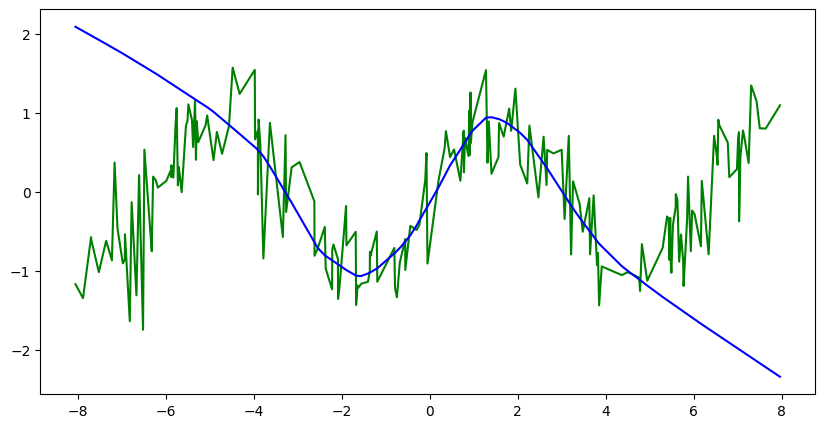

In [5]:
# Sortiere alles nach X_test für saubere Plotlinien
sort_idx = np.argsort(X_test.flatten())

X_test_sorted = X_test[sort_idx]
y_test_sorted = y_test[sort_idx]
mean_map_sorted = mean_map[sort_idx]

plt.figure(figsize=(10,5))
plt.plot(X_test_sorted, y_test_sorted, 'g-', label='True')
plt.plot(X_test_sorted, mean_map_sorted, "b-", label='MAP NN Mean')
plt.show()

In [19]:
# Base + bayesian Last Layer model
base = BaseNetwork(1).to(device)
head = nn.Linear(16,1).to(device)
baseMod = nn.Sequential(base,head)
TrainNN(baseMod,trainLoader,100)
# freezing base weights
for p in baseMod.parameters():
    p.requires_grad = False
lastLayer = BayesianLastLayer(in_features=16,out_features=1, logvals=-2.3,prior_sigma=1.5).to(device)
TrainLastLayer(base,lastLayer,trainLoader,epochs=100)
meanB, stdB = PredLastLayer(base,lastLayer,tenXTest)

Epoch: 0 | Loss: 0.41863
Epoch: 20 | Loss: 0.17433
Epoch: 40 | Loss: 0.10085
Epoch: 60 | Loss: 0.24327
Epoch: 80 | Loss: 0.11037


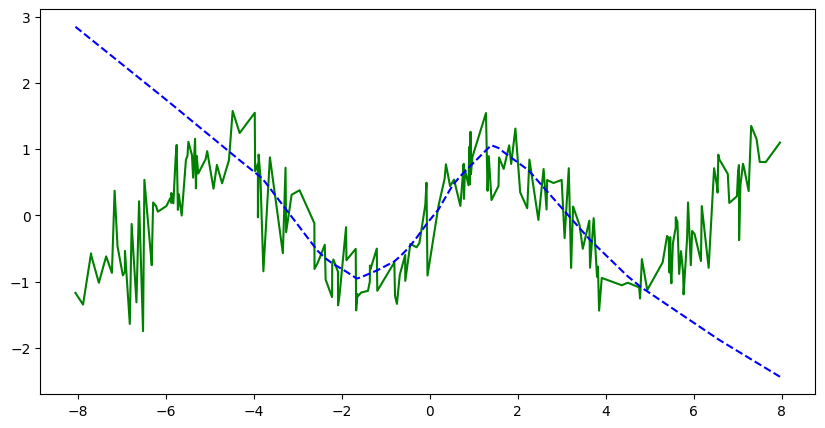

In [7]:
meanB_sorted = meanB[sort_idx]
stdB_sorted = stdB[sort_idx]
plt.figure(figsize=(10,5))
# epistemic uncertainty
plt.plot(X_test_sorted, y_test_sorted, 'g-', label='True')
plt.plot(X_test_sorted, meanB_sorted, 'b--', label='MAP NN Mean')
plt.show()


In [16]:
#
InDist = np.array(InDist)
InDist_sorted = InDist[sort_idx]
OODist = [not x for x in InDist_sorted]

mapUnID = std_map[InDist]
mapUnOOD = std_map[OODist]

bllUnID = stdB[InDist]
bllUnOOD = stdB[OODist]

print(f"MAP NN: In-dist uncertainty = {mapUnID.mean():.4f}, OOD uncertainty = {mapUnOOD.mean():.4f}")
print(f"Bayesian Last Layer: In-dist uncertainty = {bllUnID.mean():.4f}, OOD average std = {bllUnOOD.mean():.4f}")


MAP NN: In-dist uncertainty = 0.0000, OOD uncertainty = 0.0000
Bayesian Last Layer: In-dist uncertainty = 0.3762, OOD average std = 0.9784


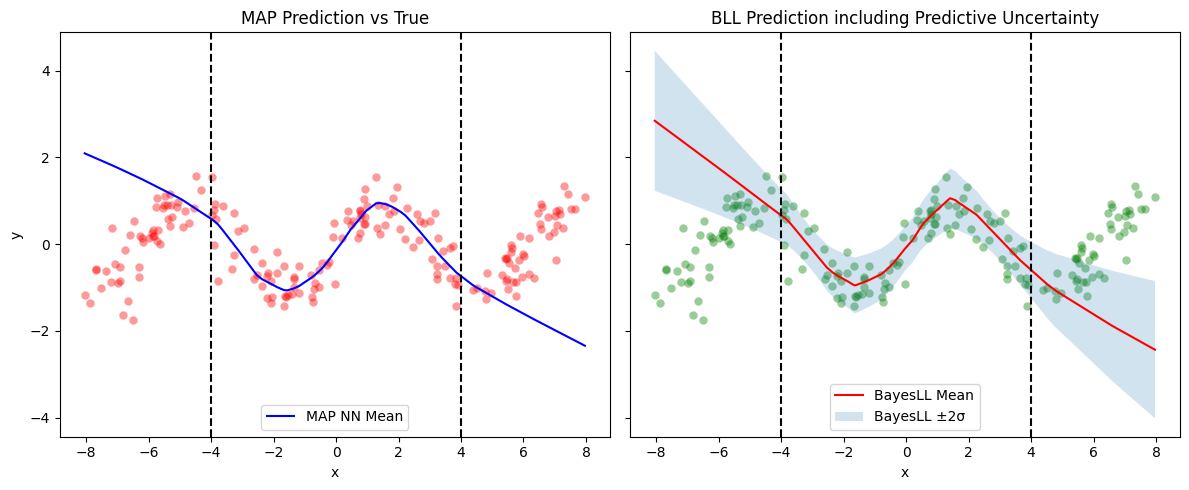

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Plot 1: MAP
ax1.scatter( X_test_sorted, y_test_sorted, alpha=0.4, linewidths=0.01, color="r" )
ax1.plot(    X_test_sorted, mean_map_sorted, 'b-', label='MAP NN Mean' )
ax1.axvline(-4, color='k', ls='--')
ax1.axvline( 4, color='k', ls='--')
ax1.legend()
ax1.set_title('MAP Prediction vs True')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Plot 2: BayesLL
ax2.scatter( X_test_sorted, y_test_sorted, alpha=0.4, linewidths=0.01, color="g" )
ax2.plot(    X_test_sorted, meanB_sorted, 'r-', label='BayesLL Mean' )
ax2.fill_between(X_test_sorted.flatten(),
                 meanB_sorted-2*stdB_sorted,
                 meanB_sorted+2*stdB_sorted,
                 alpha=0.2, label='BayesLL ±2σ')
ax2.axvline(-4, color='k', ls='--')
ax2.axvline( 4, color='k', ls='--')
ax2.legend()
ax2.set_title('BLL Prediction including Predictive Uncertainty')
ax2.set_xlabel('x')

plt.tight_layout()
plt.show()


Table for ID vs OOD MSE

In [10]:
mse_id_map = mean_squared_error(y_test_sorted[InDist_sorted],mean_map_sorted[InDist_sorted])
mse_ood_map = mean_squared_error(y_test_sorted[OODist],mean_map_sorted[OODist])

bll_id_mse =  mean_squared_error(y_test_sorted[InDist_sorted],meanB_sorted[InDist_sorted])
bll_ood_mse =  mean_squared_error(y_test_sorted[OODist],meanB_sorted[OODist])
print("MSE, MAP vs BNN:\n")
print(f"Map ID:{mse_id_map}")
print(f"Map OOD:{mse_ood_map}")
print(f"BLL ID:{bll_id_mse}")
print(f"BLL OOD:{bll_ood_mse}")


MSE, MAP vs BNN:

Map ID:0.17065054178237915
Map OOD:3.2161145210266113
BLL ID:0.1800844371318817
BLL OOD:4.0162177085876465
